# Import Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

import tweepy

from warnings import filterwarnings
filterwarnings ('ignore')

<hr style="height:2px;border-width:0;color:white;background-color:green">

# Twitter API
<br>

##### For more informations about Twitter API you can use this link.
https://developer.twitter.com/en/docs/twitter-api

In [5]:
consumer_key = 'WmqDx2vHvVTg6ZpqCVomx2qDt'
consumer_secret = '2HMXCay6lla9mRyG2A8Ion2yq0P1TsB0FmzWSUQgKRtby6dEnU'
access_token = '16065195-lcOE7dsySGMD0EETkhDM3ZnJ3iK9ZjYmcp1fzHIXM'
access_token_secret = 'vYp7EGo9JwPLHGbxK4V8rZoZ3l1nR6RKVl6ZLZRKBSLQg'

In [6]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

In [7]:
# We get the tweets with hastag "F1", in english.

tweets = api.search_tweets(q = "F!", lang = "en", count = 100)

In [8]:
def hashtag_df(tweets):
    id_list = [tweet.id for tweet in tweets]
    dataframe = pd.DataFrame(id_list, columns = ["id"])
    
    dataframe["user"] = [tweet.author.screen_name for tweet in tweets]
    dataframe["text"] = [tweet.text for tweet in tweets]
    dataframe["hashtags"] = [tweet.entities.get("hashtags") for tweet in tweets]
    
    return dataframe

In [9]:
df = hashtag_df(tweets)
df = df.drop_duplicates("user", keep = "first")
df.drop("id", axis=1, inplace=True)
df.index = df["user"]
df.drop("user", axis=1, inplace=True)

# Let's see our dataset...

df.head()

,text,hashtags
user,,
PamelaD42805040,RT @CalltoActivism: 🚨🚨🚨BREAKING: Kevin McCarth...,[]
_wxyl,RT @pledis_17: ‘F*ck My Life’ MV Behind Sketch...,"[{'text': 'SEVENTEEN', 'indices': [76, 86]}, {..."
mackl58,RT @peytonyager: 6yo William Cho is the only s...,"[{'text': 'AllenTexas', 'indices': [99, 110]}]"
MariaLo92714093,RT @CalltoActivism: 🚨🚨🚨BREAKING: Kevin McCarth...,[]
tkstkuc,RT @BABYMETAL_JAPAN: F.HERO Special Appearance...,"[{'text': 'BABYMETAL', 'indices': [52, 62]}]"


<hr style="height:2px;border-width:0;color:white;background-color:green">

# Dataset Cleaning

In [10]:
# Texts will be lower
df["text"] = df["text"].apply(lambda x: " ".join(x.lower() for x in x.split()))

# We get rid of the punctuations
df["text"] = df["text"].str.replace('[^\w\s]', '')

# And also numbers we don't need it in text.
df["text"] = df["text"].str.replace('\d', '')

# Stopwords! It is a library with some adverbs, plural suffix etc. that they are not important for the analysis
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
sw = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

# We reach to the root of the word with lemmatize.
from textblob import Word
nltk.download('wordnet')
df["text"] = df["text"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

# Retweets... We don't need them.
df["text"] = df["text"].str.replace('rt','')

# reset index
df = df.reset_index()
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ptolo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ptolo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,user,text,hashtags
0,PamelaD42805040,@calltoactivism: 🚨🚨🚨breaking: kevin mccahy f*...,[]
1,_wxyl,@pledis_17: ‘f*ck life’ mv behind sketch ▶️ h...,"[{'text': 'SEVENTEEN', 'indices': [76, 86]}, {..."
2,mackl58,@peytonyager: 6yo william cho surviving membe...,"[{'text': 'AllenTexas', 'indices': [99, 110]}]"
3,MariaLo92714093,@calltoactivism: 🚨🚨🚨breaking: kevin mccahy f*...,[]
4,tkstkuc,@babymetal_japan: f.hero special appearance ＃...,"[{'text': 'BABYMETAL', 'indices': [52, 62]}]"


<hr style="height:2px;border-width:0;color:white;background-color:green">

# Sentiment Analysis

In [11]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()

# The range of polarity is from -1 to 1(negative to positive) and will tell us if the text contains positive or negative feedback.
df["polarity_score"] = df["text"].apply(lambda x: vader.polarity_scores(x)["compound"])

# So we labeling the scores as positive or negative.
df["sentiment_label"] = df["text"].apply(lambda x: "pos" if vader.polarity_scores(x)["compound"] > df["polarity_score"].median() else "neg")

# That part is just for encoding.
df["sentiment_label"] = LabelEncoder().fit_transform(df["sentiment_label"])

df.head()

,user,text,hashtags,polarity_score,sentiment_label
0,PamelaD42805040,@calltoactivism: 🚨🚨🚨breaking: kevin mccahy f*...,[],-0.3102,0
1,_wxyl,@pledis_17: ‘f*ck life’ mv behind sketch ▶️ h...,"[{'text': 'SEVENTEEN', 'indices': [76, 86]}, {...",0.3400,1
2,mackl58,@peytonyager: 6yo william cho surviving membe...,"[{'text': 'AllenTexas', 'indices': [99, 110]}]",0.2960,1
3,MariaLo92714093,@calltoactivism: 🚨🚨🚨breaking: kevin mccahy f*...,[],-0.3102,0
4,tkstkuc,@babymetal_japan: f.hero special appearance ＃...,"[{'text': 'BABYMETAL', 'indices': [52, 62]}]",0.6597,1


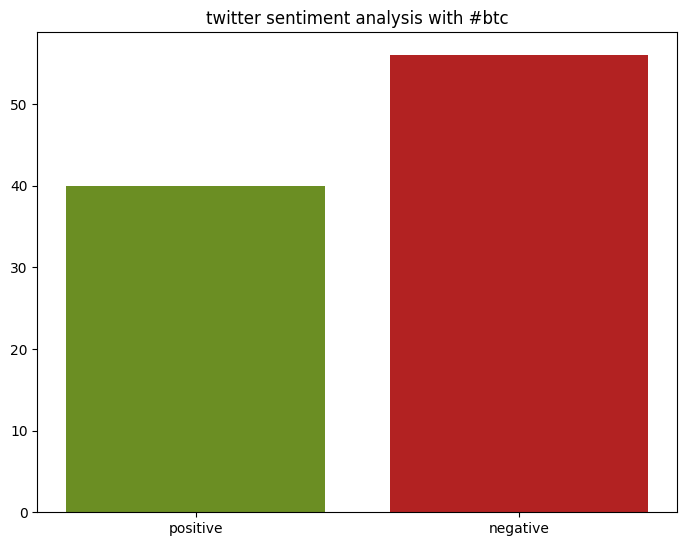

In [12]:
# Let's check the positive and negative labels...

pos = df[df["sentiment_label"]==1]["sentiment_label"].count()
neg = df[df["sentiment_label"]==0]["sentiment_label"].count()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
sent = ['positive', 'negative']
count = [pos, neg]
ax.bar(sent,count, color=["#6B8E23", '#B22222'])
ax.set_title("twitter sentiment analysis with #btc")
plt.show()

<hr style="height:2px;border-width:0;color:white;background-color:green">

# TF-IDF (Term Frequency - Inverse Document Frequency)

In [13]:
# We describe our feature and target.
y = df["sentiment_label"]  #target
X = df["text"]

# CountVectorizer returns unigrams or single words.
# If we increase the ngram_range, the vocabulary is expanded from single words to short phrases. 

# word vectorize (checking one word)
tf_idf_word_vectorizer = TfidfVectorizer()
X_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X)

# n_gram vectorize (checking double words - phrases)
tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2, 3))
X_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(X)

<hr style="height:2px;border-width:0;color:white;background-color:green">

# Sentiment Modelling

In [14]:
# word
rf_model_word = RandomForestClassifier()
rf_model_word.fit(X_tf_idf_word, y)

cross_val_score(rf_model_word,
               X_tf_idf_word,
               y,
               scoring="accuracy",
               cv=5).mean()

0.6552631578947368

In [16]:
# ngram
rf_model_ngram = RandomForestClassifier()
rf_model_ngram.fit(X_tf_idf_word, y)

cross_val_score(rf_model_ngram,
               X_tf_idf_ngram,
               y,
               scoring="accuracy",
               cv=5).mean()

0.6552631578947368

In [17]:
# Let's pick up a random tweet.

random_tweet = pd.Series(df["text"].sample(1).values)
random_tweet[0]

' @btsmemeories: f&amp;f viewer f&amp;f feature https://t.co/65j2fxicmi'

In [18]:
# Example
# random tweet analysis

random_tweet = TfidfVectorizer().fit(X).transform(random_tweet)

# with Logistic Regression by word vectorize we found better score that's why we use for a predict log_model_word..

rf_model_word.predict(random_tweet)

array([0])